In [1]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%autoreload 2

import matplotlib
import scienceplots
import matplotlib.pyplot as plt
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True



import sys
sys.path.insert(0, "/home/gh464/Documents/GitHub/SyMBac/") 
from SyMBac.drawing import raster_cell, OPL_to_FL, convert_to_3D
import numpy as np
from skimage.morphology import dilation, disk
from skimage.measure import label
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from SyMBac.drawing import raster_cell, OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
from SyMBac.PSF import PSF_generator
import tifffile
from skimage.util import img_as_uint
from skimage.transform import resize
from skimage.filters import gaussian
import os
from copy import deepcopy
import random
import sys
sys.path.insert(0, "/home/gh464/Documents/GitHub/SyMBac/") 
from SyMBac.drawing import raster_cell, OPL_to_FL, convert_to_3D
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import dilation, disk
from skimage.measure import label
from joblib import Parallel, delayed
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from SyMBac.drawing import raster_cell, OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
from SyMBac.PSF import PSF_generator
import tifffile
from skimage.util import img_as_uint
from skimage.transform import resize
import os
import scipy.integrate as integrate

def get_middle_n_elements(arr, N):
    # Ensure N is not greater than array size
    N = min(N, len(arr))
    
    # Calculate the start and end indices
    start = (len(arr) - N) // 2
    end = start + N
    
    # Return the middle N elements
    return deepcopy(arr[start:end])

In [2]:
fitted_PSF = tifffile.imread("PSF_fitted_for_single_molecule_50nm_pix.tif")
mid_z = fitted_PSF.shape[0]//2
#fitted_PSF = fitted_PSF[mid_z - OPL_cell_3D.shape[0]//2: mid_z + OPL_cell_3D.shape[0]//2]
fitted_PSF /= np.sum(fitted_PSF)

In [3]:
fitted_PSF.shape[0]//2

20

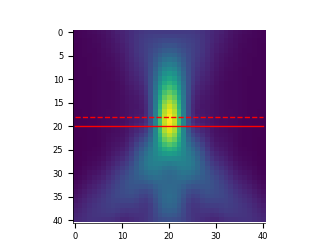

In [4]:
plt.imshow(fitted_PSF.mean(axis=(2)))
plt.plot([0, 40],[20, 20], c = "red")
plt.plot([0, 40],[18, 18], c = "red", linestyle = "--")

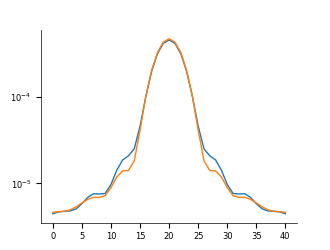

In [5]:
plt.plot(fitted_PSF[fitted_PSF.shape[0]//2][fitted_PSF.shape[1]//2])
plt.plot(fitted_PSF[18][fitted_PSF.shape[1]//2])
plt.yscale("log")

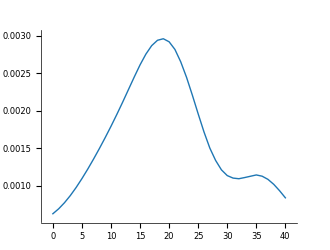

In [6]:
plt.plot(fitted_PSF.sum(axis=2)[:,fitted_PSF.shape[1]//2])

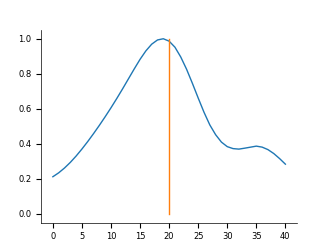

In [7]:
PSF_max_intensity = np.array([x.max() for x in fitted_PSF])
PSF_max_intensity = PSF_max_intensity/PSF_max_intensity.max()

PSF_sum_intensity = np.array([x.sum() for x in fitted_PSF])
PSF_sum_intensity = PSF_sum_intensity/PSF_sum_intensity.max()

plt.plot(fitted_PSF.sum(axis=2)[:,fitted_PSF.shape[1]//2]/fitted_PSF.sum(axis=2)[:,fitted_PSF.shape[1]//2].max())
mid_z = fitted_PSF.shape[0]//2
plt.plot([mid_z, mid_z], [0, 1])

In [8]:
from SyMBac.PSF import Camera

In [9]:
mid_z

20

In [10]:
def get_SNRs(z_plane, return_image = False):
    PSF_slice = fitted_PSF[z_plane] * (29.8 * np.random.gamma(8) / fitted_PSF[mid_z].max()) # Gives SNR = 8 for mid focus WITHUOT gaussian blur. you lose SNR when you blur, that's the price
    PSF_slice = np.pad(PSF_slice, 100)
    PSF_slice = np.random.poisson(PSF_slice).astype(np.float64)
    bg_noise = np.random.normal(570, 44, PSF_slice.shape) # Parameters from the PSF images
    PSF_slice += np.where(bg_noise > 0, bg_noise, 0)
    PSF_slice = gaussian(PSF_slice, sigma = 1, preserve_range = True, mode="constant")
    # Get the background
    mask = np.ones_like(PSF_slice, dtype=bool)
    dy, dx = fitted_PSF.shape[1]//2 + 1, fitted_PSF.shape[2]//2 + 1
    mask[PSF_slice.shape[0]//2 - dy:PSF_slice.shape[0]//2 + dy + 1, PSF_slice.shape[0]//2 - dx:PSF_slice.shape[0]//2 + dx + 1] = False
    
    # Calculate the mean of the area outside the crop
    bg = PSF_slice[mask]
    PSF_crop = PSF_slice[PSF_slice.shape[0]//2 - dy:PSF_slice.shape[0]//2 + dy + 1, PSF_slice.shape[0]//2 - dx:PSF_slice.shape[0]//2 + dx + 1]
    peak_intensity = np.percentile(PSF_crop, (1 - 16/(PSF_crop.shape[0]**2)) * 100) # Get top 9 pixels
    peak_intensity = PSF_crop[PSF_crop.shape[0]//2,PSF_crop.shape[0]//2] # Mid pixel, choose either this or top 9 pixels
    SNR = (peak_intensity - np.mean(bg))/np.std(bg)
    bg_PSNR = (np.max(bg) - np.mean(bg)) / np.std(bg)

    if return_image:
        return SNR, bg_PSNR, PSF_slice
    return SNR, bg_PSNR

SNRs = [get_SNRs(mid_z)[0] for _ in range(1000)]
np.mean(SNRs)

8.086750041672055

In [11]:
z_planes = list(range(fitted_PSF.shape[0])) * 10_00

In [12]:
SNRs, bg_PSNRs = zip(*Parallel(n_jobs=-1)(delayed(get_SNRs)(z) for z in tqdm(z_planes)))

  0%|          | 0/41000 [00:00<?, ?it/s]

In [13]:
SNR_data = pd.DataFrame()
SNR_data["SNR"] = SNRs
SNR_data["bg_PSNR"] = bg_PSNRs
SNR_data["z"] = z_planes

In [14]:
detection_threshold = np.percentile(bg_PSNRs, 99.9)

In [15]:
SNR_data["detected"] = SNR_data["SNR"] > detection_threshold

In [16]:
detection_probability = SNR_data.groupby("z").mean()

In [17]:
detection_probability_distribution = np.array(detection_probability["detected"])

Text(0, 0.5, 'Detection probability')

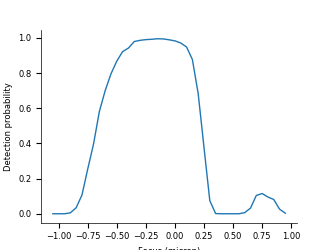

In [18]:
xdata = np.arange(-fitted_PSF.shape[0]//2,fitted_PSF.shape[0]//2) * 0.05
plt.plot(xdata, detection_probability["detected"])
plt.xlabel("Focus (micron)")
plt.ylabel("Detection probability")

In [19]:
mini_hump = np.array(detection_probability["detected"])
mini_hump[:29] = 0.

Text(0, 0.5, 'Detection probability')

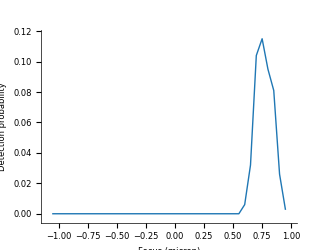

In [20]:
xdata = np.arange(-fitted_PSF.shape[0]//2,fitted_PSF.shape[0]//2) * 0.05
plt.plot(xdata, mini_hump)
plt.xlabel("Focus (micron)")
plt.ylabel("Detection probability")

In [21]:
def super_gaussian(x, sigma, P, A, x0):
    return A*np.exp(-(((x-x0)**2/(2*sigma**2))**P))

def gaussian(x, sigma, A, x0):
    return A*np.exp(-(((x-x0)**2/(2*sigma**2))))

In [22]:
from scipy.optimize import curve_fit

xdata = np.arange(-fitted_PSF.shape[0]//2,fitted_PSF.shape[0]//2) * 0.05
popt, pcov = curve_fit(super_gaussian, xdata, np.array(detection_probability["detected"]))

popt_mini_hump, pcov = curve_fit(gaussian, xdata, mini_hump)


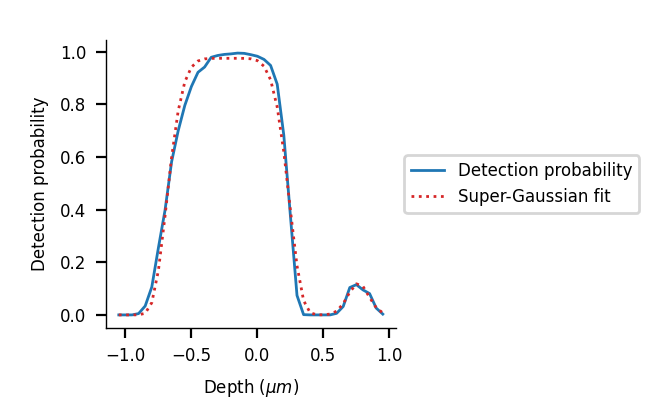

In [23]:
fig, ax = plt.subplots(1,1, figsize=(3.3,2), dpi = 200)
plt.plot(xdata, detection_probability["detected"], label = "Detection probability")
plt.xlabel("Depth ($\mu m$)")
plt.ylabel("Detection probability")
plt.plot(xdata, super_gaussian(xdata, *popt) + gaussian(xdata, *popt_mini_hump), c = "tab:red",  label = ("Super-Gaussian fit"), linestyle = ":")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.subplots_adjust(left=0.16, bottom=0.18, right=0.6, top=0.9)

plt.savefig("SI_detection_probability.png")
plt.show()

In [24]:
def combined_gaussian_fit(x):
    return super_gaussian(x, *popt) + gaussian(x, *popt_mini_hump)

In [25]:
import pickle
with open('detection_probability_data.pkl', 'wb') as f:  
    pickle.dump([xdata, super_gaussian(xdata, *popt)], f) 

In [26]:
R = 0.5
L = 5 - 2*R

def dV_cell_dz(z):
    return 2*L*np.sqrt(2*R*z-z**2) + np.pi * (2*R*z - z**2)

In [27]:
with open('cell_cross_section_profile.pkl', 'wb') as f:  
    pickle.dump([xdata, np.nan_to_num(dV_cell_dz(xdata+R))], f) 

/tmp/ipykernel_8510/1882482812.py:5: RuntimeWarning: invalid value encountered in sqrt
  return 2*L*np.sqrt(2*R*z-z**2) + np.pi * (2*R*z - z**2)


In [28]:
def calculate_diffraction_limit(wavelength, NA, criterion):
    if criterion == "Rayleigh":
        return 0.61*wavelength/NA
    if criterion == "Abbe":
        return 0.5*wavelength/NA
    if criterion == "Sparrow":
        return 0.47*wavelength/NA

In [29]:
def diffraction_limit_z(z, wavelength, NA, criterion):
    w0 = calculate_diffraction_limit(wavelength = wavelength, NA = NA, criterion = criterion)
    zr = np.pi * w0**2 * 1.51 / wavelength
    wz = w0 * np.sqrt(1 + (z/zr)**2)
    return wz

In [30]:
pixel_size = 0.05
scale = 1
pixel_size = pixel_size/scale
length = 5
width = 1
OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)
OPL_cell_3D = convert_to_3D(OPL_cell)
valid_coords = np.argwhere(convert_to_3D(OPL_cell))
FL_cell = np.zeros_like(OPL_cell_3D)
partial_det_prob_dist = get_middle_n_elements(detection_probability_distribution, OPL_cell_3D.shape[0])
N_molecules = 10
NA = 1.3

def sample_molecules(N_molecules, length = 5, width = 1 , MACS = False, return_cell = False, shift_objective = 0):

    OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)
    OPL_cell_3D = convert_to_3D(OPL_cell)
    if MACS:
        OPL_cell_3D = resize(OPL_cell_3D, (int(round(OPL_cell_3D.shape[0]*0.6)), int(round(OPL_cell_3D.shape[1]*1.2)), int(round(OPL_cell_3D.shape[2])*2.3)), anti_aliasing=True, clip=False, preserve_range=True)#.astype(int)
    valid_coords = np.argwhere(OPL_cell_3D)
    FL_cell = np.zeros_like(OPL_cell_3D)
    partial_det_prob_dist = get_middle_n_elements(detection_probability_distribution, OPL_cell_3D.shape[0])
    n_molecules_lost_DoF = 0
    for _ in range(N_molecules):
        z, y, x = random.choice(valid_coords)
        if np.random.uniform(0,1) < super_gaussian(z* pixel_size - width/2 - shift_objective, *popt): # partial_det_prob_dist[z]:
            FL_cell[z, y, x] += 1
        else:
            n_molecules_lost_DoF += 1
    
    
    
    diffraction_limited_cell = []
    for i, cell_slice in enumerate(FL_cell):
        z = (i - FL_cell.shape[0]//2) * pixel_size
        diffraction_limit = diffraction_limit_z(z, 0.515, NA, "Rayleigh")/pixel_size
        diffraction_limited_cell_slice = dilation(cell_slice, disk(diffraction_limit/2))
        diffraction_limited_cell.append(diffraction_limited_cell_slice)
    
    diffraction_limited_cell = np.array(diffraction_limited_cell)
    
    diffraction_limited_cell = label(np.sum(diffraction_limited_cell, axis = 0) > 0)
    observed_N_molecules = len(np.unique(diffraction_limited_cell))-1
    n_molecules_lost_diffraction = N_molecules - observed_N_molecules - n_molecules_lost_DoF

    labels, sizes = np.unique(diffraction_limited_cell, return_counts=True)
    sizes = np.sum(sizes[1:])
    if return_cell:
        return N_molecules, observed_N_molecules, n_molecules_lost_DoF, n_molecules_lost_diffraction,  FL_cell
    return N_molecules, observed_N_molecules, n_molecules_lost_DoF, n_molecules_lost_diffraction

In [31]:
samples = 100
test_N_molecules = [5, 10, 15, 20]*samples
normal_cell = Parallel(n_jobs=-1)(delayed(sample_molecules)(N, 5, 1) for N in tqdm(test_N_molecules))

  0%|          | 0/400 [00:00<?, ?it/s]

In [32]:
normal_cell_results = pd.DataFrame(normal_cell)
normal_cell_results.columns = ["True N molecules", "Observed N molecules", "N molecules lost to DoF", "N molecules lost to diffraction"]
normal_cell_results["Cell type"] = "1 micron"

<Axes: xlabel='True N molecules,Cell type'>

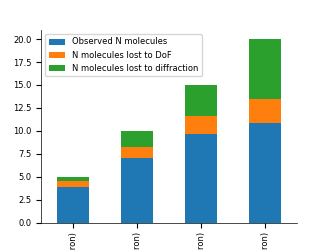

In [33]:
normal_cell_results.groupby(["True N molecules", "Cell type"]).mean(numeric_only=True).plot(kind="bar", stacked = True)

In [34]:
large_cell = Parallel(n_jobs=-1)(delayed(sample_molecules)(N, 5, 2) for N in tqdm(test_N_molecules))

  0%|          | 0/400 [00:00<?, ?it/s]

In [35]:
large_cell_results = pd.DataFrame(large_cell)
large_cell_results.columns = ["True N molecules", "Observed N molecules", "N molecules lost to DoF", "N molecules lost to diffraction"]
large_cell_results["Cell type"] = "2 micron"

<Axes: xlabel='True N molecules,Cell type'>

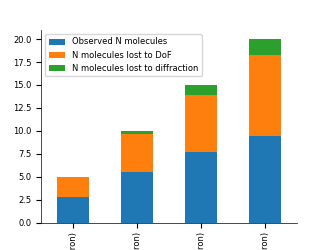

In [36]:
large_cell_results.groupby(["True N molecules", "Cell type"]).mean(numeric_only=True).plot(kind="bar", stacked = True)

<Axes: xlabel='True N molecules,Cell type'>

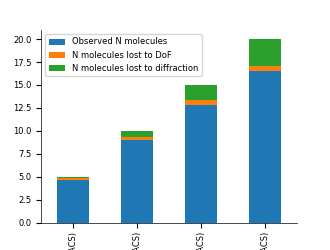

In [37]:
samples = 100
test_N_molecules = [5, 10, 15, 20]*samples
length = 5
width = 1
MACS_cell = Parallel(n_jobs=1)(delayed(sample_molecules)(N, 5, 1, True, False, -0.03) for N in (test_N_molecules))
MACS_cell_results = pd.DataFrame(MACS_cell)
MACS_cell_results.columns = ["True N molecules", "Observed N molecules", "N molecules lost to DoF", "N molecules lost to diffraction"]
MACS_cell_results["Cell type"] = "MACS"
MACS_cell_results.groupby(["True N molecules", "Cell type"]).mean(numeric_only=True).plot(kind="bar", stacked = True)

In [38]:
all_results = pd.concat([normal_cell_results, large_cell_results, MACS_cell_results])

In [39]:
all_results.to_pickle("sources_of_error.pickle")

In [40]:
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

#xdata = np.arange(-fitted_PSF.shape[0]//2,fitted_PSF.shape[0]//2) * 0.05 + R


  0%|          | 0/30000 [00:00<?, ?it/s]

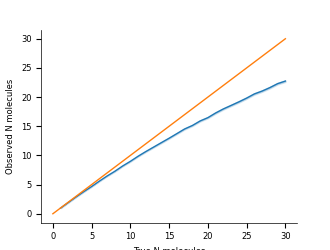

In [41]:
# For MACS cell

samples = 1000
test_N_molecules = list(range(1,31))*samples

length = 5
width = 1
naive_comparison = Parallel(n_jobs=-1)(delayed(sample_molecules)(N, 5, 1, True, False, -0.03) for N in tqdm(test_N_molecules))
naive_comparison_results = pd.DataFrame(naive_comparison)
naive_comparison_results.columns = ["True N molecules", "Observed N molecules", "N molecules lost to DoF", "N molecules lost to diffraction"]


plt.show()
sns.lineplot(data = naive_comparison_results, x = "True N molecules", y = "Observed N molecules")
plt.plot([0,30],[0,30])

naive_comparison_results_MACS = deepcopy(naive_comparison_results)
naive_comparison_results_MACS.to_pickle("naive_comparison_results_MACS.pickle")


In [42]:
# For 2 micron wide cell

samples = 500
test_N_molecules = list(range(1,31))*samples
length = 5
width = 2
naive_comparison_2um = Parallel(n_jobs=20)(delayed(sample_molecules)(N, length, width) for N in tqdm(test_N_molecules))
naive_comparison_results_2um = pd.DataFrame(naive_comparison_2um)
naive_comparison_results_2um.columns = ["True N molecules", "Observed N molecules", "N molecules lost to DoF", "N molecules lost to diffraction"]


from scipy.optimize import curve_fit

  0%|          | 0/15000 [00:00<?, ?it/s]

In [43]:
R = 1
L = 5 - 2*R

def dV_cell_dz(z):
    return 2*L*np.sqrt(2*R*z-z**2) + np.pi * (2*R*z - z**2)

In [44]:
total_volume = integrate.quad(lambda x: dV_cell_dz(x), 0, 2*R)[0]

integrate.quad(lambda x: dV_cell_dz(x)/total_volume *super_gaussian(x-R, *popt), 0, 2*R)[0] 

0.5344983826554475

In [144]:
data = sample_molecules(10000, length = 5, width = 2 , MACS = False, return_cell = True, shift_objective = 0)


In [45]:
((naive_comparison_results_2um["True N molecules"] - naive_comparison_results_2um["N molecules lost to DoF"]) / naive_comparison_results_2um["True N molecules"]).mean()

0.5687675636496838

11.196636217394033
0.5855100976207047


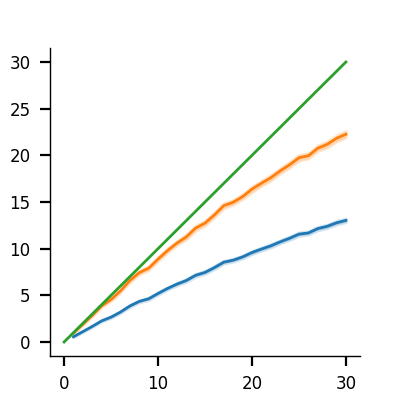

In [47]:
R = 0.9
L = 5 - 2*R

def dV_cell_dz(z):
    return 2*L*np.sqrt(2*R*z-z**2) + np.pi * (2*R*z - z**2)

fig, ax = plt.subplots(1,1, figsize=(2,2), dpi = 200)
total_volume = integrate.quad(lambda x: dV_cell_dz(x), 0, 2*R)[0]
print(total_volume)
correction_factor_basic =  integrate.quad(lambda x: dV_cell_dz(x)/total_volume * combined_gaussian_fit(x-R), 0, 2*R)[0] # Max number of observable molecules, not accounting for diffraction
print(correction_factor_basic)
naive_comparison_results_2um["Corrected"] = naive_comparison_results_2um["Observed N molecules"]/correction_factor_basic
sns.lineplot(data = naive_comparison_results_2um, x = "True N molecules", y = "Observed N molecules")
sns.lineplot(data = naive_comparison_results_2um, x = "True N molecules", y = "Corrected")
plt.plot([0,30],[0,30])

naive_comparison_results_2um.to_pickle("naive_comparison_results_2um.pickle")

0.1836734693877553


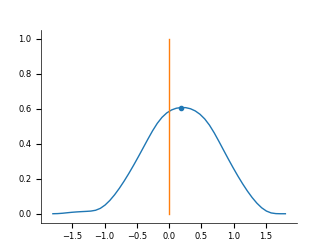

In [48]:
from scipy.signal import find_peaks
shift_interval = np.linspace(-2*R, 2*R, 50)
shifts = [integrate.quad(lambda x: dV_cell_dz(x)/total_volume * combined_gaussian_fit(x-d-R), 0, 2*R)[0] for d in shift_interval]
plt.plot(shift_interval, shifts)
peak = find_peaks(shifts)[0][0]
plt.plot([0,0],[0,1])

plt.scatter(shift_interval[peak], shifts[peak])
distance_to_shift = shift_interval[peak]
print(distance_to_shift)

In [49]:
# For 2 micron wide cell

samples = 500
test_N_molecules = list(range(1,31))*samples
length = 5
width = 2
naive_comparison_2um_shifted = Parallel(n_jobs=-1)(delayed(sample_molecules)(N, length, width, False, False, distance_to_shift) for N in tqdm(test_N_molecules))
naive_comparison_results_2um_shifted = pd.DataFrame(naive_comparison_2um_shifted)
naive_comparison_results_2um_shifted.columns = ["True N molecules", "Observed N molecules", "N molecules lost to DoF", "N molecules lost to diffraction"]



  0%|          | 0/15000 [00:00<?, ?it/s]

In [ ]:
naive_comparison_results_2um_shifted["Uncorrected"] = naive_comparison_results_2um_shifted["Corrected"] + naive_comparison_results_2um_shifted["N molecules lost to diffraction"]

11.196636217394033
0.6070211357070157


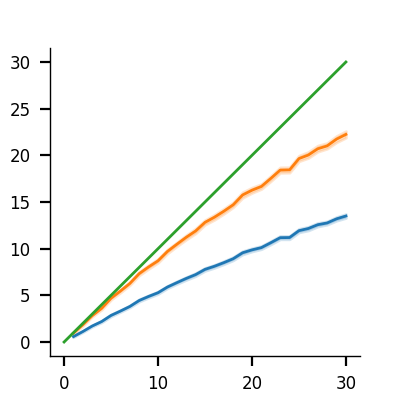

In [51]:

R = 0.9
L = 5 - 2*R


#plt.plot(xdata, super_gaussian(xdata- R, *popt), c = "r")
#plt.plot(xdata, ydata)


def dV_cell_dz(z):
    return 2*L*np.sqrt(2*R*z-z**2) + np.pi * (2*R*z - z**2)

total_volume = integrate.quad(lambda x: dV_cell_dz(x), 0, 2*R)[0]
print(total_volume)
correction_factor_basic =  integrate.quad(lambda x: dV_cell_dz(x)/total_volume * combined_gaussian_fit(x-R - distance_to_shift), 0, 2*R)[0] # Max number of observable molecules, not accounting for diffraction
print(correction_factor_basic)
naive_comparison_results_2um_shifted["Corrected"] = naive_comparison_results_2um_shifted["Observed N molecules"]/correction_factor_basic

fig, ax = plt.subplots(1,1, figsize=(2,2), dpi = 200)
sns.lineplot(data = naive_comparison_results_2um_shifted, x = "True N molecules", y = "Observed N molecules")
sns.lineplot(data = naive_comparison_results_2um_shifted, x = "True N molecules", y = "Corrected")
plt.plot([0,30],[0,30])


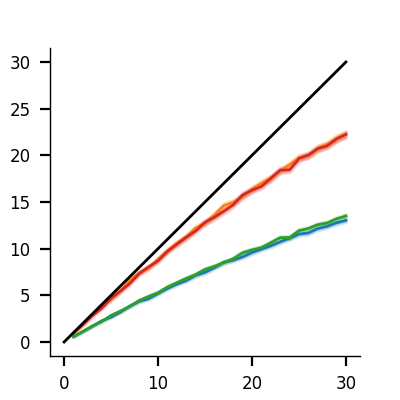

In [56]:
fig, ax = plt.subplots(1,1, figsize=(2,2), dpi = 200)

sns.lineplot(data = naive_comparison_results_2um, x = "True N molecules", y = "Observed N molecules")
sns.lineplot(data = naive_comparison_results_2um, x = "True N molecules", y = "Corrected")


sns.lineplot(data = naive_comparison_results_2um_shifted, x = "True N molecules", y = "Observed N molecules")
sns.lineplot(data = naive_comparison_results_2um_shifted, x = "True N molecules", y = "Corrected")

plt.plot([0,30],[0,30], c = "k")


In [130]:
samples = 500
test_N_molecules = list(range(1,31))*samples
length = 5
width = 1
naive_comparison_1um = Parallel(n_jobs=-1)(delayed(sample_molecules)(N, length, width) for N in tqdm(test_N_molecules))
naive_comparison_results_1um = pd.DataFrame(naive_comparison_1um)
naive_comparison_results_1um.columns = ["True N molecules", "Observed N molecules", "N molecules lost to DoF", "N molecules lost to diffraction"]
naive_comparison_results_1um.to_pickle("naive_comparison_results.pickle")
R = 0.9/2
L = 5 - 2*R
#plt.plot(xdata, super_gaussian(xdata - 2*R, *popt), c = "r")
#plt.plot(xdata, ydata)
#plt.show()
def dV_cell_dz(z):
    return 2*L*np.sqrt(2*R*z-z**2) + np.pi * (2*R*z - z**2)

total_volume = integrate.quad(lambda x: dV_cell_dz(x), 0, 2*R)[0]

correction_factor_basic =  integrate.quad(lambda x: dV_cell_dz(x)/total_volume * super_gaussian(x-R, *popt), 0, 2*R)[0] # Max number of observable molecules, not accounting for diffraction
print(correction_factor_basic)
naive_comparison_results_1um["Corrected"] = naive_comparison_results_1um["Observed N molecules"]/correction_factor_basic
naive_comparison_results_1um.to_pickle("naive_comparison_results_1um.pickle")




  0%|          | 0/15000 [00:00<?, ?it/s]

0.7812675938100501


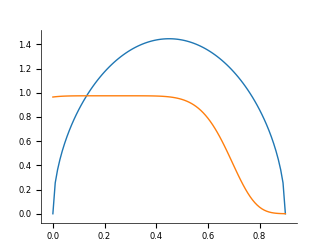

In [131]:
x = np.linspace(0,2*R, 100)
plt.plot(x, dV_cell_dz(x)/total_volume)
plt.plot(x, super_gaussian(x-R, *popt))

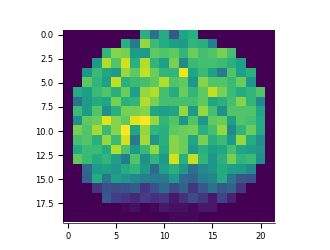

In [132]:
length = 5
width = 1.1
data = sample_molecules(10000, length, width, False, True, -0)
plt.imshow(data[-1].sum(axis=1))

In [133]:
(10000-1646)/10000

0.8354

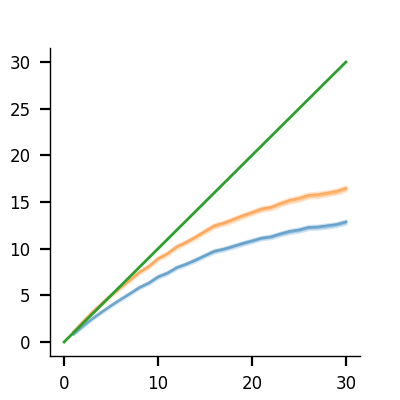

In [134]:
fig, ax = plt.subplots(1,1, figsize=(2,2), dpi = 200)
sns.lineplot(data = naive_comparison_results_1um, x = "True N molecules", y = "Observed N molecules", alpha = 0.5)
sns.lineplot(data = naive_comparison_results_1um, x = "True N molecules", y = "Corrected", alpha = 0.5)
plt.plot([0,30],[0,30])

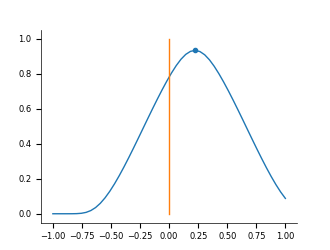

In [136]:
shifts = [integrate.quad(lambda x: dV_cell_dz(x)/total_volume * super_gaussian(x-d-R, *popt), 0, 2*R)[0] for d in np.linspace(-1,1,50)]
plt.plot(np.linspace(-1,1,50), shifts)
peak = find_peaks(shifts)[0][0]
plt.plot([0,0],[0,1])

plt.scatter(np.linspace(-1,1,50)[peak], shifts[peak])
distance_to_shift = np.linspace(-1,1,50)[peak]

In [140]:
samples = 500
test_N_molecules = list(range(1,31))*samples
length = 5
width = 1
naive_comparison_1um_shifted = Parallel(n_jobs=-1)(delayed(sample_molecules)(N, length, width, False, False, distance_to_shift) for N in tqdm(test_N_molecules))
naive_comparison_results_1um_shifted = pd.DataFrame(naive_comparison_1um_shifted)
naive_comparison_results_1um_shifted.columns = ["True N molecules", "Observed N molecules", "N molecules lost to DoF", "N molecules lost to diffraction"]

#plt.plot(xdata, super_gaussian(xdata - 2*R, *popt), c = "r")
#plt.plot(xdata, ydata)
plt.show()
R = 0.9/2
L = 5 - 2*R

total_volume = integrate.quad(lambda x: dV_cell_dz(x), 0, 2*R)[0]

correction_factor_basic =  integrate.quad(lambda x: dV_cell_dz(x)/total_volume * super_gaussian(x-R - distance_to_shift, *popt), 0, 2*R)[0] # Max number of observable molecules, not accounting for diffraction
print(correction_factor_basic)
naive_comparison_results_1um_shifted["Corrected"] = naive_comparison_results_1um_shifted["Observed N molecules"]/correction_factor_basic

naive_comparison_results_1um_shifted.to_pickle("naive_comparison_results_1um_DoF_corrected.pickle")

  0%|          | 0/15000 [00:00<?, ?it/s]

0.9334716977272736


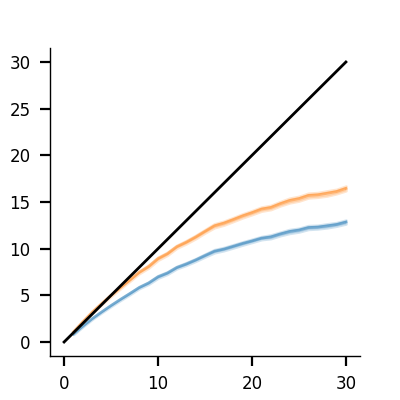

In [141]:
fig, ax = plt.subplots(1,1, figsize=(2,2), dpi = 200)

sns.lineplot(data = naive_comparison_results_1um, x = "True N molecules", y = "Observed N molecules", alpha = 0.5)
sns.lineplot(data = naive_comparison_results_1um, x = "True N molecules", y = "Corrected", alpha = 0.5)
plt.plot([0,30],[0,30], c = "k")

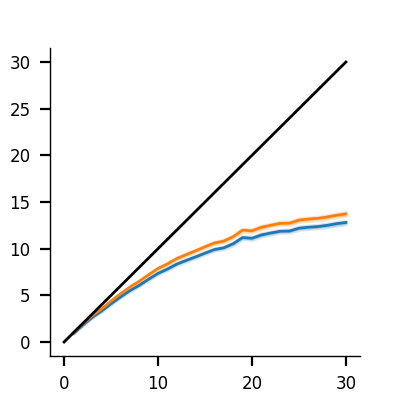

In [142]:
fig, ax = plt.subplots(1,1, figsize=(2,2), dpi = 200)
#sns.lineplot(data = naive_comparison_results_1um, x = "True N molecules", y = "Observed N molecules", alpha = 0.5)
sns.lineplot(data = naive_comparison_results_1um_shifted, x = "True N molecules", y = "Observed N molecules")
sns.lineplot(data = naive_comparison_results_1um_shifted, x = "True N molecules", y = "Corrected")
plt.plot([0,30],[0,30], c = "k")

In [101]:
def diffraction_limit_z_shifted(z, wavelength, NA, criterion):
    w0 = calculate_diffraction_limit(wavelength = wavelength, NA = NA, criterion = criterion)
    zr = np.pi * w0**2 * 1.51 / wavelength
    wz = w0 * np.sqrt(1 + (z/zr)**2)
    return wz

In [138]:
avg_ER_p = integrate.quad(
    lambda z: np.pi*(diffraction_limit_z_shifted(z-R, 0.515, 1.39, "Rayleigh"))**2 / dV_cell_dz(z) * super_gaussian(z-R, *popt), 0, 2*R
)[0]
avg_ER_p

0.04987702886657845

In [112]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def generate_er_network(n, p):
    """Generates an Erdős-Rényi network graph with n nodes and edge probability p."""
    G = nx.erdos_renyi_graph(n, p)
    return G

def plot_graph(G):
    """Plots the graph G."""
    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True, node_color='lightblue')
    plt.show()

def analyze_network(G):
    """Analyzes the generated network graph G for its components and isolated nodes."""
    # Get all connected components
    components = list(nx.connected_components(G))
    num_components = len(components)
    isolated_nodes = list(nx.isolates(G))
    num_isolated_nodes = len(isolated_nodes)
    
    return num_components, num_isolated_nodes, components



In [128]:
Ns = list(range(1,30))*1000

In [125]:
Ns = [int(np.random.normal(10, 2)) for _ in range(10000)]

In [129]:
#Ns = [5]*10000

In [130]:
def p_weight_func(N,p,k):
    return 1/(1+np.exp(k*(p*N-1)))

In [131]:
N = 5
N**(1.05) /N

1.0837983867343683

  0%|          | 0/29000 [00:00<?, ?it/s]

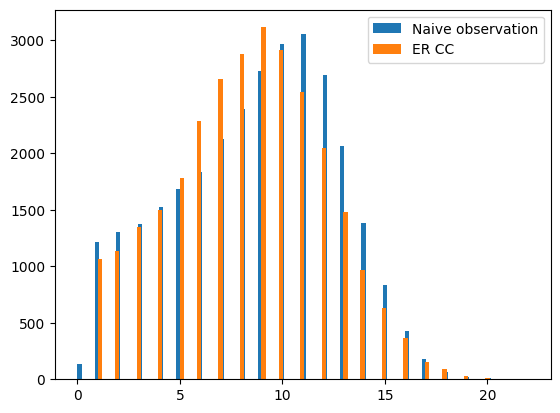

In [132]:

# Parameters
def get_CC(N):        
    G = generate_er_network(N, avg_ER_p ) # * N**(1.35) /N
    num_components, num_isolated_nodes, components = analyze_network(G)
    return num_components

connected_components = Parallel(n_jobs=-1)(delayed(get_CC)(N) for N in tqdm(Ns))

plt.hist(naive_comparison_results["Observed N molecules"], bins = 100, label = "Naive observation")
plt.hist(connected_components, bins = 100, label = "ER CC")
plt.legend()
plt.show()


Text(0.5, 0, 'Connected components')

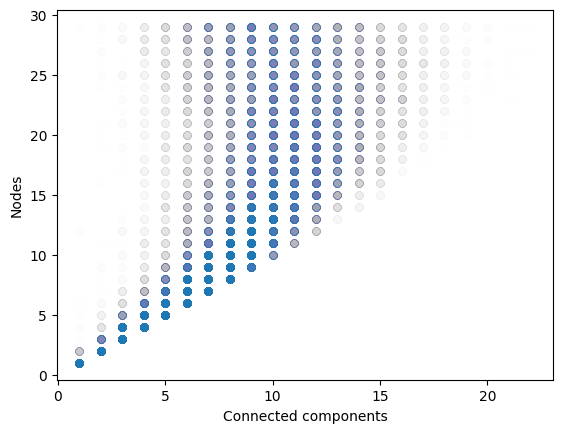

In [133]:
plt.scatter(connected_components, Ns, alpha = 0.005)
plt.ylabel("Nodes")
plt.xlabel("Connected components")
#plt.plot(np.arange(1,30), p(np.arange(1,30)))

In [139]:
df = pd.DataFrame([Ns, connected_components]).T
#for i in range(31):
#    df = pd.concat([df, pd.DataFrame([i,i]).T])
df.columns = ["X", "Y"]
df.reset_index(inplace=True, drop=True)



def weight_function(x):
    return 1+0.1*x  # Change the exponent to control the bias strength

# Apply the weight function to X
df['Weight'] = df['X'].apply(weight_function)

# Calculate weighted joint probabilities P(X=x and Y=y)
weighted_counts = df.groupby(['Y', 'X']).agg({'Weight': 'sum'})
total_weights = weighted_counts.groupby('Y').transform('sum')
weighted_joint_prob = weighted_counts / total_weights

# Flatten the index and prepare for max operation
weighted_joint_prob = weighted_joint_prob.reset_index()

# Identify the X with the highest weighted probability for each Y
most_probable_x_weighted = weighted_joint_prob.loc[weighted_joint_prob.groupby('Y')['Weight'].idxmax()]
most_probable_x_weighted["X"] = most_probable_x_weighted["X"]#**1.12
# Print results
print(most_probable_x_weighted[['Y', 'X', 'Weight']])

#plt.scatter(most_probable_x_weighted["Y"], most_probable_x_weighted["X"])

ER_corrected = []
for x in range(len(naive_comparison_results)):
    obs = naive_comparison_results["Observed N molecules"].iloc[x]
    obs = int(obs)
    try:
        if obs == 0:
            ER_corrected.append(0)
        else:
            corrected =  most_probable_x_weighted.query("Y == @obs")["X"].iloc[0]
            ER_corrected.append(corrected)
    except:
        ER_corrected.append(np.nan)

naive_comparison_results["ER corrected"] = ER_corrected



      Y   X    Weight
0     1   1  0.926784
8     2   2  0.801752
27    3   3  0.598141
50    4   4  0.388216
76    5   5  0.248196
101   6   6  0.141087
126   7   8  0.103940
149   8   9  0.073509
172   9  11  0.061081
194  10  13  0.058919
224  11  24  0.061013
244  12  26  0.071190
257  13  22  0.079340
275  14  24  0.092206
291  15  25  0.100802
302  16  23  0.120282
317  17  26  0.154998
329  18  27  0.162535
339  19  27  0.188295
346  20  29  0.314516
351  21  29  0.216667
353  22  29  0.513158


Text(0.5, 0, 'most probable')

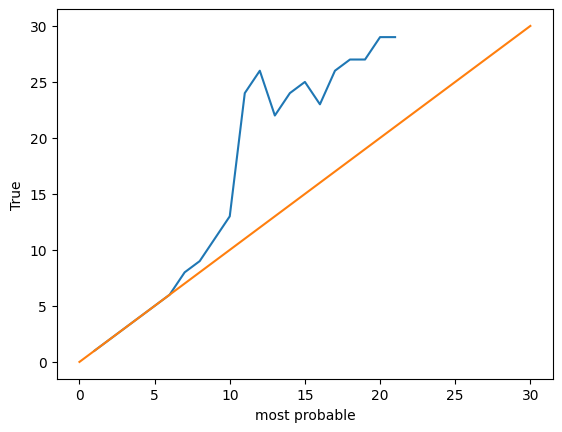

In [140]:
plt.plot(range(1,most_probable_x_weighted["Y"].max()), [(most_probable_x_weighted.query("Y == @x")["X"].iloc[0]) for x in range(1,most_probable_x_weighted["Y"].max())])
plt.plot([0,30],[0,30])
plt.ylabel("True")
plt.xlabel("most probable")

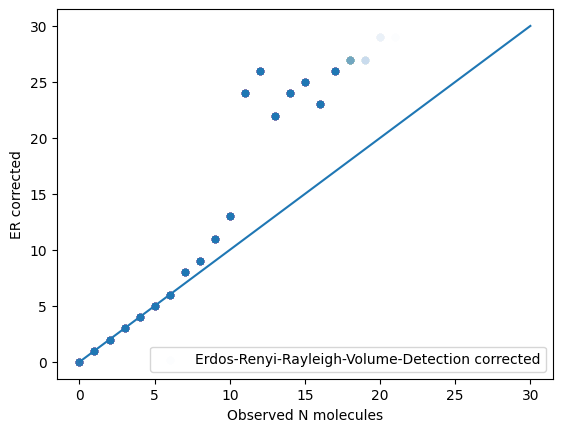

In [141]:
sns.scatterplot(data = naive_comparison_results, x = "Observed N molecules", y = "ER corrected", label = "Erdos-Renyi-Rayleigh-Volume-Detection corrected", alpha = 0.01)
plt.plot([0,30],[0,30])


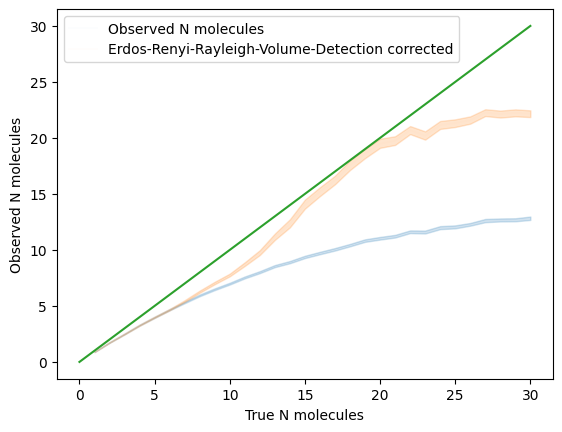

In [142]:
sns.lineplot(data = naive_comparison_results, x = "True N molecules", y = "Observed N molecules", label = "Observed N molecules", alpha = 0.01)
sns.lineplot(data = naive_comparison_results, x = "True N molecules", y = "ER corrected", label = "Erdos-Renyi-Rayleigh-Volume-Detection corrected", alpha = 0.01)
#sns.scatterplot(data = naive_comparison_results, x = "True N molecules", y = "Corrected", label = "Depth only correction")

plt.plot([0,30],[0,30])
plt.legend()

<Axes: xlabel='CC', ylabel='Nodes'>

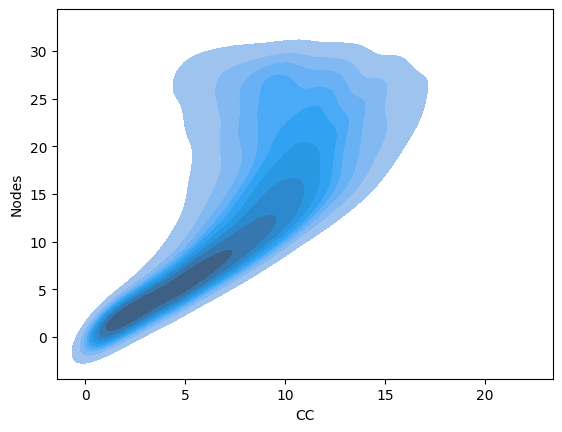

In [83]:
df = pd.DataFrame([Ns, connected_components]).T
for i in range(31):
    df = pd.concat([df, pd.DataFrame([i,i]).T])
df.columns = ["Nodes", "CC"]

sns.kdeplot(data = df.sample(10000), x = "CC", y = "Nodes",fill=True)

